# Creation of synthetic data set

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import multivariate_normal
import numpy as np


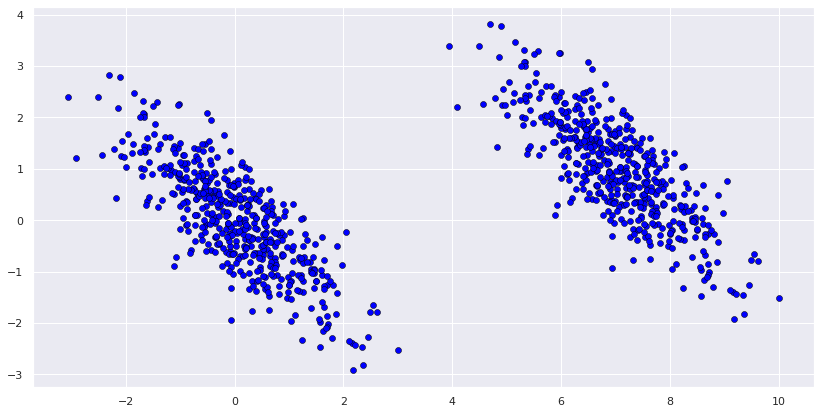

In [7]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
from sklearn.datasets import make_blobs


plt.rcParams['figure.figsize']=14,7

# Initializing the random seed
random_seed=1000
 
cov_val = [-0.8, -0.8]
mean = np.array([[0,0], [7,1]])

X = np.zeros((1000,2))
 
# Iterating over different covariance
# values
for idx, val in enumerate(cov_val):
    #plt.subplot(1,3,idx+1)
     
    # Initializing the covariance matrix
    cov = np.array([[1, val], [val, 1]])
     
    # Generating a Gaussian bivariate distribution
    # with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean[idx],
                                seed = random_seed)
     
    # Generating 500 samples out of the
    # distribution
    data = distr.rvs(size = 500)
     
    X[500*idx:500*(idx+1)][:] = data
    
# Plotting the generated samples
plt.plot(X[:,0],X[:,1], 'o',markeredgewidth = 0.5,color='blue',markeredgecolor = 'black')


# Generation of coresets

In [8]:
# Variables:

# X: Dataset                             X.shape = (num_of_datapoints, dimension)
# B: approximation for cluster centers?  B.shape = (num_clusters, dimension)

In [9]:
from sklearn.cluster import kmeans_plusplus

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.kmeans_plusplus.html

p = 10 #int(np.ceil(np.log2(1/delta)))
num_clusters = 2
dimension = 2
centers = np.zeros([num_clusters, dimension, p])

B, idx = kmeans_plusplus(X, n_clusters=num_clusters)

for i in range(p):
    centers[:,:,i], indices = kmeans_plusplus(X, n_clusters=num_clusters)

Implementation of distance function:
$$ d(x, B) = \min_{b \in B} || x - b || $$

In [10]:
def dist(x, B):
    """
    x = array of length dimension
    B.shape = (num_clusters, dimension)
    
    return min_b \in B | x - B|
    """
    (num_clusters, dimension) = B.shape
    #for i in range(num_clusters):
    #    print(np.linalg.norm(x - B[i]))
    return np.min([np.linalg.norm(x - B[i]) for i in range(num_clusters)])

Implementation of phi:
    $$ \phi(X, B) = \sum_{x \in X} d(x, B)^2 $$

In [11]:
def phi(X, B):
    """
    X.shape = (num_of_datapoints, dimension)
    B.shape = (num_clusters, dimension)
    
    return: sum_x \in X d(x, B)
    """
    (num_of_datapoints, dimension) = X.shape
    sum_of_dist = 0
    for i in range(num_of_datapoints):
        distance = dist(X[i], B)
        sum_of_dist += distance*distance
        
    return sum_of_dist

In [12]:
# Compute input for coreset algorithm, as in Theorem 2 in https://arxiv.org/pdf/1703.08110v2.pdf

alpha = 16*(np.log2(num_clusters)+2)
p = 50#int(np.ceil(np.log2(1/delta)))

# compute multiple B's
Bs = np.zeros([num_clusters, dimension, p])
for i in range(p):
    Bs[:,:,i], indices = kmeans_plusplus(X, n_clusters=num_clusters)

# compute B* = argmin_i∈{1,...,p} φ(X , B_i)
phi_evaluation = [phi(X, Bs[:,:,i]) for i in range(p)]
argmin_index = np.argmin(phi_evaluation)
B_star = Bs[:,:,argmin_index]

In [13]:
from numpy.random import default_rng
def coreset(X, B, approx_factor_alpha, coreset_size_m, is_uniform=False):
    """
    X.shape = (num_of_datapoints, dimension)
    B.shape = (num_clusters, dimension)
    approx_factor_alpha = 16*(np.log2(num_clusters)+2)
    coreset_size_m is size of coreset
    """
    (num_of_datapoints, dimension) = X.shape
    (num_of_clusters,_) = B.shape
    
    # Voronoi partition
    voronoi_partition = np.zeros(num_of_datapoints)
    for i in range(num_of_datapoints):
        # compute distance to all points in B
        # check for each x in X, if x is nearest to b1, ..., bn
        # (x, i), where i is index of Bi, where x is closest
        argmin_index = np.argmin([np.linalg.norm(X[i] - B[j]) for j in range(num_clusters)])
        voronoi_partition[i] = argmin_index
        
    # 
    s = np.zeros(num_of_datapoints)
    
    sumForThirdSummand = sum([dist(X[iprime], B)*dist(X[iprime], B) for iprime in range(num_of_datapoints)])
    for j in range(num_of_clusters):
        # consider only x in X with voronoi index = j
        indices = [i for i in range(num_of_datapoints) if voronoi_partition[i] == j]
        # for each i in X_j
        for i in indices:
            firstSummand = alpha*dist(X[i], B)*dist(X[i], B)
            secondSummand = 2*alpha/len(indices)*sum([dist(X[iprime], B)*dist(X[iprime], B) for iprime in indices])
            thirdSummand = 2/len(indices)*sumForThirdSummand
            s[i] = firstSummand + secondSummand + thirdSummand
        
    
    # compute weights
    # q is vector of size num_of_datapoints
    # assume for now uniform sampling
    q = np.zeros(num_of_datapoints)
    sumS = sum(s)
    for i in range(num_of_datapoints):
        q[i] = s[i]/sumS 
        
    # sample subset
    # coreset dimension C.shape = (coreset_size_m, 2), where first component stores datapoint, 2nd component=weight
    C = np.zeros([coreset_size_m, dimension+1])
    
    # sampling without replacement
    rng = default_rng()
    #if is_uniform:
    #    p = 1/num_of_datapoints*np.ones(num_of_datapoints)
    #else:
    #    p=q/sum(q)
    sampled_indices = rng.choice(range(num_of_datapoints), size=coreset_size_m, replace=False, p=s/sum(s))
    
    C[:,0:dimension] = X[sampled_indices]
    C[:,dimension] = 1/(coreset_size_m*q[sampled_indices])
    
    return C

In [14]:
Cs = []
ws = []

for i in range(5):
    C1 = coreset(X, B_star, alpha, 6)

    Cs += [C1[:,[0,1]]]
    ws += [C1[:,[2]]]

In [16]:
import pickle

# save the generated coresets
with open('coresets/Cs_coreset_6.pickle', 'wb') as handle:
    pickle.dump(Cs, handle)
    
with open('coresets/ws_coreset_6.pickle', 'wb') as handle:
    pickle.dump(ws, handle)